# EDSA Apple Prices Challenge

Imagine you are in the Fresh Produce Industry. How much stock do you have on hand? Not too little that you run out of stock when customers want to buy more. And not too much that food waste occurs. How do you set your prices? Yields from farms fluctuate by season. Should your prices then also fluctuate by season?

With this context, EDSA is challenging you to construct a regression algorithm, capable of accurately predicting how much a kilogram of Golden Delicious Apples will cost, given certain parameters.

Providing an accurate and robust solution to this challenge has immense economic potential, with users of the system being able to accurately determine how much stock to have on hand and what price to set the Golden Delicious Apples to.

## Data Overview

This dataset consists of over 60 000 sales made by [Durban Fresh Produce Market](http://www.durban.gov.za/Online_Tools/Pages/Fresh_Produce_Price_Reporting.aspx). In this notebook, we use this data to predict the average price per kilogram of Golden Delicious Apples.

Below is a brief description for each data field:
- Province - Which province the produce was grown
- Container - The code for the type of container
- Size_Grade - The class of the produce according to their quality
- Weight_Kg - The total weight in kilograms
- Commodities - The type of produce, e.g. Golden Delicious Apples
- Date - The date of the sale
- Sales_Total - The total sales price
- Total_Qty_Sold - The number of produce sold
- Total_Kg_Sold - The total weight of the produce sold in kilograms
- Stock_On_Hand - The amount of produce the store has

<h1>Table of Contents</h1>
<ul>
    <li><a href="#eda">Exploratiory Data Analysis</a></li>
    <li><a href="#modeldevelopment">Model Development</a></li>
    <li><a href="#modelevaluation">Model Selection</a></li>
    <li><a href="#modelselection">Model Selection</a></li>
</ul>

In [1]:
# Regression models
from sklearn.linear_model import LinearRegression

# Model slection
from sklearn.model_selection import train_test_split

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# Visualisations
#import missingno
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Other
import numpy as np
import pandas as pd
from scipy import stats
import math
import pickle

<h1 id="edsa"> Exploratory Data Analysis   </h1>
<p>

### Basic Analysis 

In [2]:
# import the data
train = pd.read_csv('df-train_set.csv')
test = pd.read_csv('df-test_set.csv')

In [3]:
train.head()

,Province,Container,Size_Grade,Weight_Kg,Commodities,Date,Low_Price,High_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand,avg_price_per_kg
0,CAPE,EC120,1L,12.0,APPLE GRANNY SMITH,2020-03-10,108.0,112.0,3236.0,29,348.0,0,9.30
1,CAPE,M4183,1L,18.3,APPLE GOLDEN DELICIOUS,2020-09-09,150.0,170.0,51710.0,332,6075.6,822,8.51
2,GAUTENG,AT200,1L,20.0,AVOCADO PINKERTON,2020-05-05,70.0,80.0,4860.0,66,1320.0,50,3.68
3,TRANSVAAL,BJ090,1L,9.0,TOMATOES-LONG LIFE,2020-01-20,60.0,60.0,600.0,10,90.0,0,6.67
4,WESTERN FREESTATE,PP100,1R,10.0,POTATO SIFRA (WASHED),2020-07-14,40.0,45.0,41530.0,927,9270.0,393,4.48


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64376 entries, 0 to 64375
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Province          64376 non-null  object 
 1   Container         64376 non-null  object 
 2   Size_Grade        64376 non-null  object 
 3   Weight_Kg         64376 non-null  float64
 4   Commodities       64376 non-null  object 
 5   Date              64376 non-null  object 
 6   Low_Price         64376 non-null  float64
 7   High_Price        64376 non-null  float64
 8   Sales_Total       64376 non-null  float64
 9   Total_Qty_Sold    64376 non-null  int64  
 10  Total_Kg_Sold     64376 non-null  float64
 11  Stock_On_Hand     64376 non-null  int64  
 12  avg_price_per_kg  64376 non-null  float64
dtypes: float64(6), int64(2), object(5)
memory usage: 6.4+ MB


In [5]:
train.shape

(64376, 13)

In [6]:
train.isnull().sum()

Province            0
Container           0
Size_Grade          0
Weight_Kg           0
Commodities         0
Date                0
Low_Price           0
High_Price          0
Sales_Total         0
Total_Qty_Sold      0
Total_Kg_Sold       0
Stock_On_Hand       0
avg_price_per_kg    0
dtype: int64

In [7]:
train1 = train.copy()

In [9]:
#filtering the data to what we need to look at: Golden Delicious Apples
train1 = train[train['Commodities'] == 'APPLE GOLDEN DELICIOUS']
train1

,Province,Container,Size_Grade,Weight_Kg,Commodities,Date,Low_Price,High_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand,avg_price_per_kg
1,CAPE,M4183,1L,18.3,APPLE GOLDEN DELICIOUS,2020-09-09,150.0,170.0,51710.0,332,6075.6,822,8.51
7,CAPE,JG110,2M,11.0,APPLE GOLDEN DELICIOUS,2020-04-14,50.0,50.0,16000.0,320,3520.0,0,4.55
24,W.CAPE-BERGRIVER ETC,JE090,2S,9.0,APPLE GOLDEN DELICIOUS,2020-04-16,55.0,55.0,990.0,18,162.0,1506,6.11
40,CAPE,M4183,1S,18.3,APPLE GOLDEN DELICIOUS,2020-05-04,80.0,120.0,32020.0,388,7100.4,443,4.51
69,EASTERN CAPE,IA400,1S,400.0,APPLE GOLDEN DELICIOUS,2020-09-28,1800.0,1800.0,1800.0,1,400.0,2,4.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...
64276,NATAL,EC120,1S,12.0,APPLE GOLDEN DELICIOUS,2020-03-04,96.0,96.0,1920.0,20,240.0,53,8.00
64291,ORANGE FREE STATE,M4183,1X,18.3,APPLE GOLDEN DELICIOUS,2020-02-22,130.0,130.0,7280.0,56,1024.8,74,7.10
64297,CAPE,JE090,2M,9.0,APPLE GOLDEN DELICIOUS,2020-04-22,50.0,60.0,4540.0,89,801.0,793,5.67
64304,CAPE,JG110,2M,11.0,APPLE GOLDEN DELICIOUS,2020-03-04,30.0,40.0,2140.0,70,770.0,0,2.78


### Univariate Analysis: Non-Graphical

In [13]:
train1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1952 entries, 1 to 64310
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Province          1952 non-null   object 
 1   Container         1952 non-null   object 
 2   Size_Grade        1952 non-null   object 
 3   Weight_Kg         1952 non-null   float64
 4   Commodities       1952 non-null   object 
 5   Date              1952 non-null   object 
 6   Low_Price         1952 non-null   float64
 7   High_Price        1952 non-null   float64
 8   Sales_Total       1952 non-null   float64
 9   Total_Qty_Sold    1952 non-null   int64  
 10  Total_Kg_Sold     1952 non-null   float64
 11  Stock_On_Hand     1952 non-null   int64  
 12  avg_price_per_kg  1952 non-null   float64
dtypes: float64(6), int64(2), object(5)
memory usage: 213.5+ KB


In [10]:
#Descriptive Statistics
train1.describe()

,Weight_Kg,Low_Price,High_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand,avg_price_per_kg
count,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000
mean,40.460912,174.307377,215.648053,20053.533811,174.510758,2960.176332,408.393955,6.778893
std,99.655169,373.553578,433.546159,39005.069445,308.810797,6097.416527,724.450582,2.248744
min,3.000000,2.000000,5.000000,5.000000,1.000000,3.000000,0.000000,0.250000
25%,9.000000,50.000000,60.000000,1325.000000,12.000000,219.600000,9.000000,5.460000
50%,12.000000,80.000000,108.000000,5495.000000,64.000000,853.500000,126.500000,6.670000
75%,18.300000,127.250000,160.000000,21082.500000,200.000000,3093.525000,468.000000,8.280000
max,400.000000,2300.000000,3300.000000,369464.000000,4237.000000,74000.000000,6400.000000,21.240000


In [11]:
train1.mode(axis = 'index')

,Province,Container,Size_Grade,Weight_Kg,Commodities,Date,Low_Price,High_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand,avg_price_per_kg
0,CAPE,M4183,1S,18.3,APPLE GOLDEN DELICIOUS,2020-07-20,50.0,60.0,500.0,1,9.0,0,6.67


In [12]:
train1.shape

(1952, 13)

In [14]:
#checking distrubution of the data
train.skew()

Weight_Kg           10.746241
Low_Price           10.071797
High_Price           9.519075
Sales_Total          7.372393
Total_Qty_Sold       9.448153
Total_Kg_Sold        7.171355
Stock_On_Hand       13.767932
avg_price_per_kg          NaN
dtype: float64

In [15]:
train1.skew()

Weight_Kg           3.328254
Low_Price           4.222672
High_Price          3.828819
Sales_Total         4.250317
Total_Qty_Sold      4.445169
Total_Kg_Sold       5.529586
Stock_On_Hand       3.391815
avg_price_per_kg    0.082452
dtype: float64

In [16]:
#checking for outliers in the data
train.kurt()

Weight_Kg           116.022033
Low_Price           123.977754
High_Price          109.763276
Sales_Total          89.378966
Total_Qty_Sold      152.646835
Total_Kg_Sold        83.222862
Stock_On_Hand       437.075702
avg_price_per_kg           NaN
dtype: float64

In [17]:
train1.kurt()

Weight_Kg            9.109698
Low_Price           17.073369
High_Price          13.630768
Sales_Total         24.200524
Total_Qty_Sold      32.338123
Total_Kg_Sold       45.153801
Stock_On_Hand       14.671224
avg_price_per_kg     1.042921
dtype: float64

### Univariate Analysis: Graphical

<AxesSubplot:>

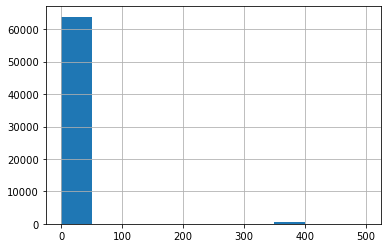

In [20]:
train['Weight_Kg'].hist()

<AxesSubplot:>

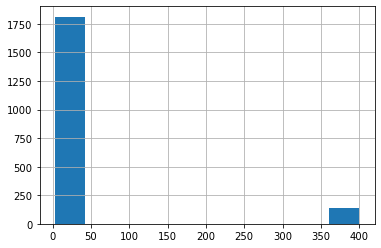

In [23]:
train1['Weight_Kg'].hist()

<AxesSubplot:xlabel='count', ylabel='Size_Grade'>

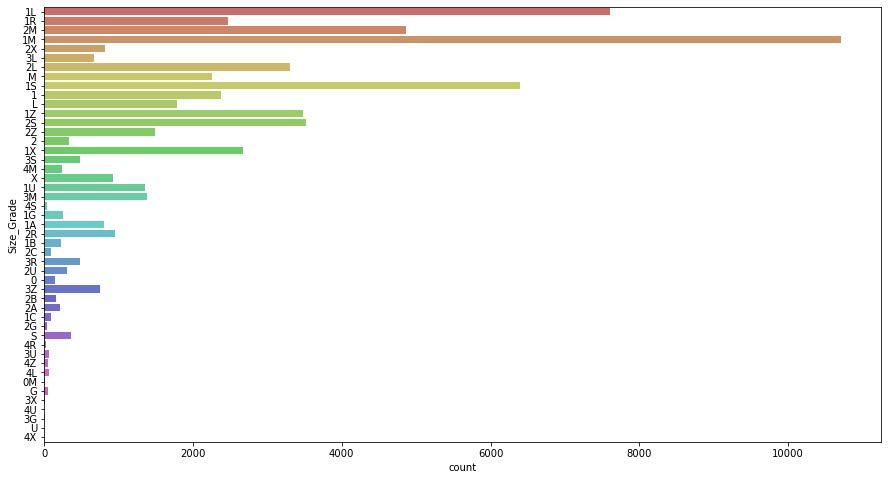

In [33]:
plt.figure(figsize=(15,8))
sns.countplot(y = 'Size_Grade', data = train, palette="hls")


ValueError: supplied range of [-inf, inf] is not finite

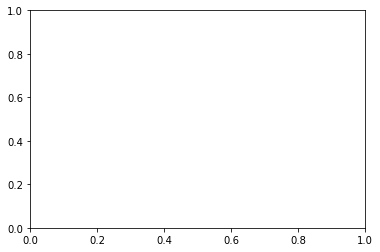

In [38]:
train['avg_price_per_kg'].hist()

### Multivariate Analysis: Non-Graphical 

In [35]:
train.corr()

,Weight_Kg,Low_Price,High_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand,avg_price_per_kg
Weight_Kg,1.000000,0.832214,0.846184,0.007710,-0.055573,0.032639,-0.039879,-0.054991
Low_Price,0.832214,1.000000,0.962504,-0.006438,-0.093333,-0.031281,-0.062260,0.124585
High_Price,0.846184,0.962504,1.000000,0.029433,-0.082580,-0.000889,-0.046742,0.123440
Sales_Total,0.007710,-0.006438,0.029433,1.000000,0.750116,0.920337,0.265030,-0.000303
Total_Qty_Sold,-0.055573,-0.093333,-0.082580,0.750116,1.000000,0.735714,0.347718,-0.037589
Total_Kg_Sold,0.032639,-0.031281,-0.000889,0.920337,0.735714,1.000000,0.236541,-0.077350
Stock_On_Hand,-0.039879,-0.062260,-0.046742,0.265030,0.347718,0.236541,1.000000,-0.025811
avg_price_per_kg,-0.054991,0.124585,0.123440,-0.000303,-0.037589,-0.077350,-0.025811,1.000000


In [36]:
train1.corr()

,Weight_Kg,Low_Price,High_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand,avg_price_per_kg
Weight_Kg,1.000000,0.863182,0.905852,0.180518,-0.133317,0.294117,-0.144105,-0.337886
Low_Price,0.863182,1.000000,0.938140,0.183230,-0.122823,0.269744,-0.127677,-0.141740
High_Price,0.905852,0.938140,1.000000,0.265672,-0.096456,0.372282,-0.094174,-0.164496
Sales_Total,0.180518,0.183230,0.265672,1.000000,0.771865,0.962338,0.284693,0.108473
Total_Qty_Sold,-0.133317,-0.122823,-0.096456,0.771865,1.000000,0.651440,0.390168,0.087536
Total_Kg_Sold,0.294117,0.269744,0.372282,0.962338,0.651440,1.000000,0.229062,-0.001007
Stock_On_Hand,-0.144105,-0.127677,-0.094174,0.284693,0.390168,0.229062,1.000000,0.105028
avg_price_per_kg,-0.337886,-0.141740,-0.164496,0.108473,0.087536,-0.001007,0.105028,1.000000


### Multivariate Analysis: Graphical

### Descriptive Statistical Analysis

### Grouping Data 

### Correlation and Causation

### ANOVA 

<h1 id="modeldevelopment">Model Development  </h1>
<p>

<h1 id="modelevaluation">Model Evaluation  </h1>
<p>

<h1 id="modelselection">Model Selection, Overfitting and Underfitting  </h1>
<p>

# Submission